# TP - Parte 2
#### Análisis de datos sobre dataset ["Crímenes reportados en Chicago", año 2024](https://data.cityofchicago.org/Public-Safety/Crimes-2024/dqcy-ctma/about_data) -- Continuación --
#### 

### Consignas
El análisis debe abordar los siguientes aspectos:
 * Análisis de balance/desbalance de clases ante un posible problema de clasificación.
    * Plantear/describir el problema y analizar la variable target.
    * Proponer y aplicar mecanismos de balance en caso de ser necesario y justificar la selección.
 * Análisis y selección de features:
    * Implementar tests estadísticos para evaluar relaciones entre features.
    * Realizar una selección de variables basándose en su relevancia y significancia.
    * Justificar la elección de las variables seleccionadas.
    * Crear nuevos features en caso de ser necesario. Justificar.
 * Transformación de variables:
    * Aplicar técnicas de conversión de variables, por ejemplo: codificación, discretización.
    * Escalar y / o normalizar los features.
 * Reducción de la dimensionalidad:
    * Implementar dos técnicas de reducción de la dimensionalidad. Comparar.
    * Comparar el dataset original con el dataset reducido, evaluando las ventajas y desventajas de la reducción.
    * Analizar cómo la reducción de la dimensionalidad afecta la interpretación y el rendimiento de futuros modelos predictivos.

#### Integrantes:
* Mealla Pablo
* Viñas Gustavo

In [1]:
# Import de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_theme()

### Cargamos el dataset analizado en la parte 1

In [2]:
# Carga del dataset
df_csv = pd.read_parquet("dataset/tp1.parquet", engine="fastparquet")

# Análisis inicial de columnas y cantidad de datos, para comparar y estar seguros que el dataset se cargó correctamente
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256840 entries, 13709672 to 13656417
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  256840 non-null  datetime64[ns]
 1   IUCR                  256840 non-null  category      
 2   Primary Type          256840 non-null  category      
 3   Description           256840 non-null  category      
 4   Location Description  256840 non-null  category      
 5   Arrest                256840 non-null  int64         
 6   Domestic              256840 non-null  int64         
 7   Beat                  256840 non-null  category      
 8   District              256840 non-null  category      
 9   Ward                  256840 non-null  category      
 10  Community Area        256840 non-null  category      
 11  FBI Code              256840 non-null  category      
 12  Latitude              256840 non-null  float64       


### Análisis de desbalances
Considerando a FBI Code como la variable target analizamos el desbalance entre categorías

In [3]:
# Calcular el porcentaje de las primeras 15 categoría de 'FBI Code'
targ = df_csv['FBI Code'].value_counts(normalize=True) * 100

# Mostrar las 15 más frecuentes
print(targ.head(15))

FBI Code
06     23.810154
08B    14.915512
14     11.104189
07      8.441053
08A     7.614079
26      7.334138
11      5.109407
03      3.552796
04B     3.184473
15      3.127628
04A     3.074287
05      2.976561
18      2.320511
02      0.678633
24      0.642034
Name: proportion, dtype: float64


Recordemos como se observa gráficamente la distribución y desbalance en FBI CODE:

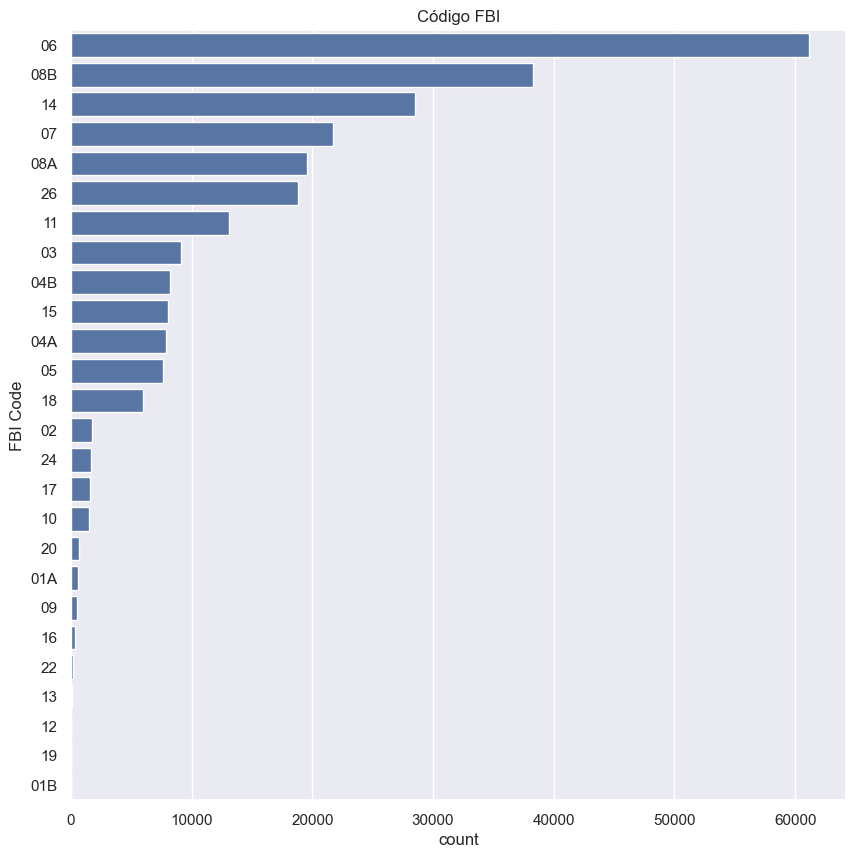

In [4]:
# Graficamos la distribución de FBI Code

fig, ax = plt.subplots(figsize=(10, 10))
# código FBI
sns.countplot(data=df_csv, y='FBI Code', order=df_csv['FBI Code'].value_counts().index, ax=ax)
ax.set_title('Código FBI')
plt.show()

Observamos la Matriz de confusión:

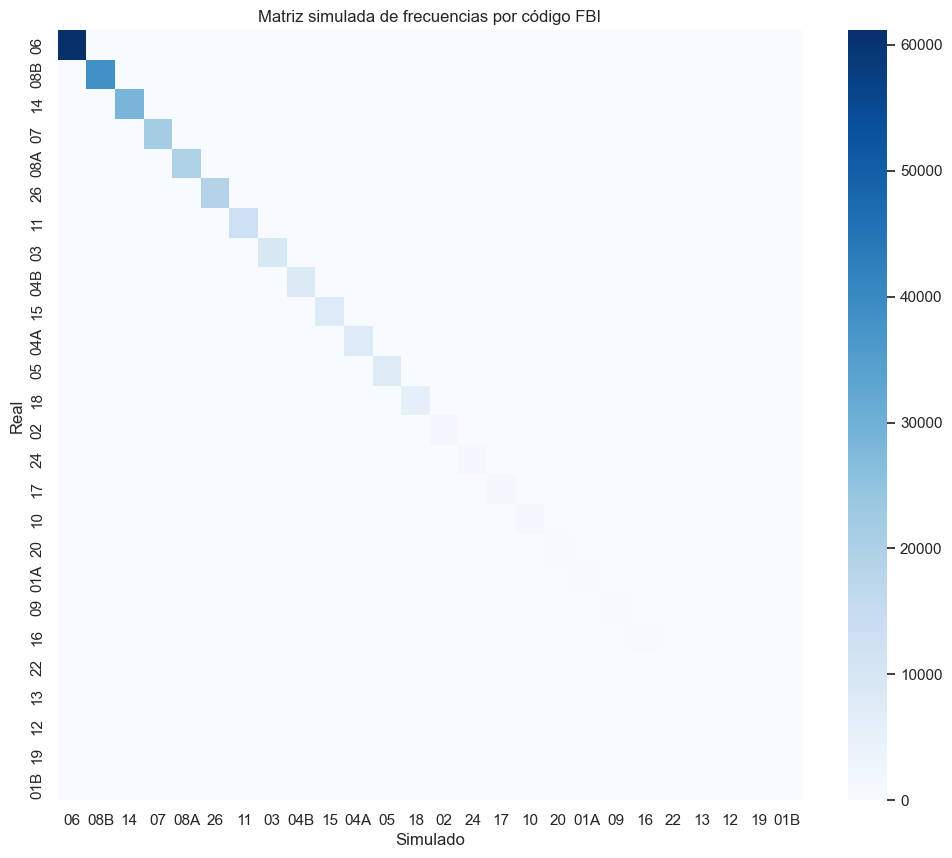

In [5]:
# Contar ocurrencias por clase
counts = df_csv['FBI Code'].value_counts()

# Crear matriz de confusión simulada
conf_matrix = pd.DataFrame(0, index=counts.index, columns=counts.index)
for code in counts.index:
    conf_matrix.loc[code, code] = counts[code]

# Visualizar con heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz simulada de frecuencias por código FBI")
plt.xlabel("Simulado")
plt.ylabel("Real")
plt.show()

#### En la matriz se puede observar cierto desbalance:

* Clases con muchas muestras → cuadros más oscuros en la diagonal.

* Clases raras → cuadros pálidos.

#### Para concluir si realmente el desbalance que observamos requiere un tratamiento, calculamos:
* Indice de Gini
* Y la entropía de Shannon


In [6]:
import numpy as np

# Calcular proporciones
proporciones = df_csv['FBI Code'].value_counts(normalize=True)

# Cantidad de categorías
num_categ = df_csv['FBI Code'].nunique()
#print(f"Número de categorías únicas: {num_categorias}")

# Calcular el índice de Gini
gini = 1 - sum(proporciones**2)

print(f"Índice de Gini para 'FBI Code': {gini:.4f}")

# Calcular entropía de Shannon
entropia = -sum(proporciones * np.log2(proporciones))
entropia_max = np.log2(num_categ)
print(f"Entropía de Shannon para FBI Code: {entropia:.4f}")
print(f"Entropía de Shannon máxima teórica: {entropia_max:.4f}")



Índice de Gini para 'FBI Code': 0.8820
Entropía de Shannon para FBI Code: 3.5200
Entropía de Shannon máxima teórica: 4.7004


Según los valores observados tanto para el Indice de Gini como para la Entropía de Shannon no es necesario realizar un banlanceo, los valores son relativamente aceptables. 

### Creación de features

Consideramos que agregar la estación del año (Season) puede ayudar al modelo sabiendo que los crímenes también están relaciones al clima estacional.

Anteriormente para el TP1 ya se habían agregados los siguientes features para el análisis puntual de crimenes por día y horario:

* "Hour"
* "Day Of Week"
* "Day"
* "Month"
  

In [8]:
# Función para determinar la estación del año
def get_season(date):
    month = date.month
    day = date.day
    
    if (month == 12 and day >= 21) or (month == 1) or (month == 2) or (month == 3 and day < 20):
        return 'Invierno'
    elif (month == 3 and day >= 20) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return 'Primavera'
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 23):
        return 'Verano'
    else:
        return 'Otoño'

# Aplicar la función para crear la nueva columna "Season"
df_csv['Season'] = df_csv['Date'].apply(get_season).astype('category')

# Verificar el resultado
display(df_csv[['Date', 'Season']].head())
#display(df_csv.head())

,Date,Season
ID,,
13709672,2024-12-31 23:58:00,Invierno
13707925,2024-12-31 23:56:00,Invierno
13708038,2024-12-31 23:55:00,Invierno
13709164,2024-12-31 23:53:00,Invierno
13707823,2024-12-31 23:50:00,Invierno


### Transformación de variables - Encoding

Para empezar el análisis, observamos la cardinalidad de las variables categóricas que queremos codificar


In [10]:

# Variables que queremos analizar
variables_categoricas = [
    'Primary Type', 
    'Description', 
    'Location Description', 
    'FBI Code', 
    'Season'
]

# Contar categorías únicas
for col in variables_categoricas:
    print(f"{col}: {df_csv[col].nunique()} categorías únicas")

Primary Type: 31 categorías únicas
Description: 318 categorías únicas
Location Description: 128 categorías únicas
FBI Code: 26 categorías únicas
Season: 4 categorías únicas


#### Según la cardinalidad y el tipo de categoría podemos codificar las variables de la siguiente forma:

* Para las variables "Primary Type", "Description" y "Location Description" elegimos "Frecuency Encoding"
* Para la variable tarjet "FBI Code": Debido a que los modelos de clasificación suvervisada requieren un target numérico, necesitamos codificar el Feature "FBI Code" y elegimos el "Ordinal Encoder"


In [11]:
# Encode para variables "Primary Type", "Description" y "Location Description"

# Frequency Encoding para Primary Type
freq_encoding = df_csv["Primary Type"].value_counts(normalize=True)
df_csv["Primary_Type_Encode"] = df_csv["Primary Type"].map(freq_encoding)

# Frequency Encoding para Description
freq_encoding = df_csv["Description"].value_counts(normalize=True)
df_csv["Description_Encode"] = df_csv["Description"].map(freq_encoding)

# Frequency Encoding para Location Description
freq_encoding = df_csv["Location Description"].value_counts(normalize=True)
df_csv["Location_Description_Encode"] = df_csv["Location Description"].map(freq_encoding)

df_csv.head()


,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,...,Latitude,Longitude,Hour,Day Of Week,Day,Month,Season,Primary_Type_Encode,Description_Encode,Location_Description_Encode
ID,,,,,,,,,,,,,,,,,,,,,
13709672,2024-12-31 23:58:00,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,0,0,332,3,5,...,41.771470,-87.590742,23,1,31,12,Invierno,0.111042,0.047208,0.191380
13707925,2024-12-31 23:56:00,1365,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,1,1,223,2,3,...,41.808501,-87.616563,23,1,31,12,Invierno,0.019242,0.004812,0.191380
13708038,2024-12-31 23:55:00,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,0,1,834,8,18,...,41.752749,-87.741498,23,1,31,12,Invierno,0.179365,0.003917,0.004867
13709164,2024-12-31 23:53:00,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,0,0,321,3,20,...,41.774269,-87.599710,23,1,31,12,Invierno,0.111042,0.061645,0.270779
13707823,2024-12-31 23:50:00,0460,BATTERY,SIMPLE,SIDEWALK,0,0,2531,25,29,...,41.902858,-87.770537,23,1,31,12,Invierno,0.179365,0.122641,0.053726


In [12]:
#Encode para variable FBI Code

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Asegurarse que sea tipo string
df_csv['FBI Code'] = df_csv['FBI Code'].astype(str)

# Crear encoder
ordinalencoder = OrdinalEncoder()

# Aplicar ordinal encoding 
df_csv['FBI_Code_encoded'] = ordinalencoder.fit_transform(df_csv[['FBI Code']]).astype(int)


# Mostrar primeros resultados
print(df_csv[['FBI Code', 'FBI_Code_encoded']].head())

#display(df_csv.head())

         FBI Code  FBI_Code_encoded
ID                                 
13709672       14                16
13707925       26                25
13708038      04B                 5
13709164       14                16
13707823      08B                10


In [13]:

# Inicializar codificador
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


# Aplicar codificación
season_encoded = encoder.fit_transform(df_csv[['Season']])

# Obtener nombres de columnas codificadas
season_cols = encoder.get_feature_names_out(['Season'])

# Crear DataFrame con codificación y unir al original
df_encoded = pd.DataFrame(season_encoded, columns=season_cols, index=df_csv.index)
df_csv = pd.concat([df_csv, df_encoded], axis=1)

# Opcional: eliminar la columna original 'season'
#df.drop(columns=['season'], inplace=True)

# Verificar resultado
print(df_csv.filter(like='Season_').head())

          Season_Invierno  Season_Otoño  Season_Primavera  Season_Verano
ID                                                                      
13709672              1.0           0.0               0.0            0.0
13707925              1.0           0.0               0.0            0.0
13708038              1.0           0.0               0.0            0.0
13709164              1.0           0.0               0.0            0.0
13707823              1.0           0.0               0.0            0.0


In [14]:
display(df_csv.head())

,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,...,Month,Season,Primary_Type_Encode,Description_Encode,Location_Description_Encode,FBI_Code_encoded,Season_Invierno,Season_Otoño,Season_Primavera,Season_Verano
ID,,,,,,,,,,,,,,,,,,,,,
13709672,2024-12-31 23:58:00,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,0,0,332,3,5,...,12,Invierno,0.111042,0.047208,0.191380,16,1.0,0.0,0.0,0.0
13707925,2024-12-31 23:56:00,1365,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,1,1,223,2,3,...,12,Invierno,0.019242,0.004812,0.191380,25,1.0,0.0,0.0,0.0
13708038,2024-12-31 23:55:00,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,0,1,834,8,18,...,12,Invierno,0.179365,0.003917,0.004867,5,1.0,0.0,0.0,0.0
13709164,2024-12-31 23:53:00,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,0,0,321,3,20,...,12,Invierno,0.111042,0.061645,0.270779,16,1.0,0.0,0.0,0.0
13707823,2024-12-31 23:50:00,0460,BATTERY,SIMPLE,SIDEWALK,0,0,2531,25,29,...,12,Invierno,0.179365,0.122641,0.053726,10,1.0,0.0,0.0,0.0
